<a href="https://colab.research.google.com/github/soroushmirzaei/convolutional-neural-networks-projects/blob/main/sign-language-recognition/sign-language-recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#import requirements libraries
import os
import zipfile
import time

#import mathematics statics libraries
import numpy as np
import pandas as pd

#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

#import machine learning deep learning libraries
import tensorflow as tf
from tensorflow import keras

In [ ]:
# sign_mnist_train.csv
!gdown 1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
# sign_mnist_test.csv
!gdown 1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg


Downloading...
From: https://drive.google.com/uc?id=1z0DkA9BytlLxO1C0BAWzknLyQmZAp0HR
To: /content/sign_mnist_train.csv
100% 83.3M/83.3M [00:00<00:00, 138MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z1BIj4qmri59GWBG4ivMNFtpZ4AXIbzg
To: /content/sign_mnist_test.csv
100% 21.8M/21.8M [00:00<00:00, 124MB/s]


In [ ]:
#load training validation dataset
train_data = pd.read_csv('/content/sign_mnist_train.csv')
valid_data = pd.read_csv('/content/sign_mnist_test.csv')


In [ ]:
#define input and output of the model
inp_train = train_data.drop('label', axis = 1)
out_train = train_data['label']

inp_valid = valid_data.drop('label', axis = 1)
out_valid = valid_data['label']

#return array and expand dims
inp_train = np.expand_dims(inp_train.values, -1)
out_train = out_train.values

inp_valid = np.expand_dims(inp_valid.values, -1)
out_valid = out_valid.values

#reshape input data
inp_train = np.reshape(inp_train, (-1,28,28,1))
inp_valid = np.reshape(inp_valid, (-1,28,28,1))


In [ ]:
Height = 150
Width = 150
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255,
                                                         height_shift_range = 0.1, width_shift_range = 0.1,
                                                         zoom_range = 0.1, fill_mode = 'nearest')
train_data = keras.preprocessing.image.NumpyArrayIterator(inp_train, out_train, train_gen,
                                                          seed = 0)

test_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)
test_data = keras.preprocessing.image.NumpyArrayIterator(inp_valid, out_valid, test_gen,
                                                         seed = 0)


In [ ]:
#create model function
def create_model(inp_shape, conv_layers_num, conv_filters, conv_kernel_size,
                 dense_layers_num, dense_drop_ratio, dense_units, out_drop_ratio, out_units, out_activation,
                 compile_optimizer, compile_loss , compile_metric, conv_activation = 'relu', dense_activation = 'relu',
                 #layers batch drop configuration
                 conv_base = True, dense_head = True, batch_norm_conv = True,
                 batch_norm_dense = True, batch_norm_out = True, drop_dense = True, drop_out = True):
    
    input = keras.Input(inp_shape)
    out = input

    #define convolution layers
    if conv_base:
        for i in range(conv_layers_num):
            if batch_norm_conv:
                out = keras.layers.BatchNormalization()(out)
            out = keras.layers.Conv2D(filters = conv_filters[i],
                                      kernel_size = conv_kernel_size[i], activation = conv_activation,
                                      kernel_initializer = keras.initializers.GlorotNormal(), padding = 'same')(out)
            out = keras.layers.MaxPool2D(pool_size = 2, padding = 'same')(out)

    #convert two dims to one dim
    out = keras.layers.Flatten()(out)

    #define dense layers
    if dense_head:
        for i in range(dense_layers_num):
            if batch_norm_dense:
                out = keras.layers.BatchNormalization()(out)
            out = keras.layers.Dense(units = dense_units[i], activation = dense_activation,
                                     kernel_initializer = keras.initializers.HeNormal())(out)
            if drop_dense:
                out = keras.layers.Dropout(dense_drop_ratio[i])(out)

    #define output layers
    if batch_norm_out:
        out = keras.layers.Dropout(out_drop_ratio)(out)
    if drop_out:
        out = keras.layers.BatchNormalization()(out)
    output = keras.layers.Dense(units = out_units, activation = out_activation)(out)

    model = keras.models.Model(input, output)

    #define model compile
    model.compile(optimizer = compile_optimizer,
                  loss = compile_loss,
                  metrics = compile_metric)

    return model


In [ ]:
#define custom callbacks
class callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        self.model.save('/content/sign-language-recognition-model.h5')
        

In [ ]:
#create model
model = create_model(inp_shape = (inp_train.shape[1], inp_train.shape[2], 1),
                     conv_layers_num = 3, conv_filters = [128, 128, 128], conv_kernel_size = [3, 3, 3],
                     dense_layers_num = 2, dense_drop_ratio = [0.3, 0.3] , dense_units = [512, 512], out_drop_ratio = 0.3, out_units = 26,
                     out_activation = 'softmax', compile_optimizer = 'adam', compile_loss ='sparse_categorical_crossentropy' ,
                     compile_metric = ['accuracy'],
                     conv_activation = 'relu', dense_activation = 'relu', conv_base = True, dense_head = True,
                     batch_norm_conv = True, batch_norm_dense = True, batch_norm_out = True, drop_dense = True, drop_out = True)


In [ ]:
#print model summary
model.summary(120)


Model: "model"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 input_1 (InputLayer)                                 [(None, 28, 28, 1)]                             0                 
                                                                                                                        
 batch_normalization (BatchNormalization)             (None, 28, 28, 1)                               4                 
                                                                                                                        
 conv2d (Conv2D)                                      (None, 28, 28, 128)                             1280              
                                                                                                                        
 max_pooling2d (M

In [ ]:
#fit model for training
model.fit(train_data, validation_data = test_data, epochs = 50,
          callbacks = [keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True, monitor = 'val_accuracy'),
                       callback(), keras.callbacks.ReduceLROnPlateau('val_accuracy', patience = 2, factor = 0.01)]
          )


Epoch 1/50
858/858 [==============================] - 25s 15ms/step - loss: 0.8479 - accuracy: 0.7423 - val_loss: 0.0601 - val_accuracy: 0.9835 - lr: 0.0010
Epoch 2/50
858/858 [==============================] - 12s 14ms/step - loss: 0.1289 - accuracy: 0.9585 - val_loss: 0.0104 - val_accuracy: 0.9974 - lr: 0.0010
Epoch 3/50
858/858 [==============================] - 12s 15ms/step - loss: 0.0827 - accuracy: 0.9733 - val_loss: 0.0117 - val_accuracy: 0.9948 - lr: 0.0010
Epoch 4/50
858/858 [==============================] - 13s 15ms/step - loss: 0.0569 - accuracy: 0.9823 - val_loss: 0.0067 - val_accuracy: 0.9987 - lr: 0.0010
Epoch 5/50
858/858 [==============================] - 14s 17ms/step - loss: 0.0494 - accuracy: 0.9846 - val_loss: 0.0262 - val_accuracy: 0.9915 - lr: 0.0010
Epoch 6/50
858/858 [==============================] - 12s 14ms/step - loss: 0.0455 - accuracy: 0.9852 - val_loss: 0.0127 - val_accuracy: 0.9950 - lr: 0.0010
Epoch 7/50
858/858 [==============================] - 13s 

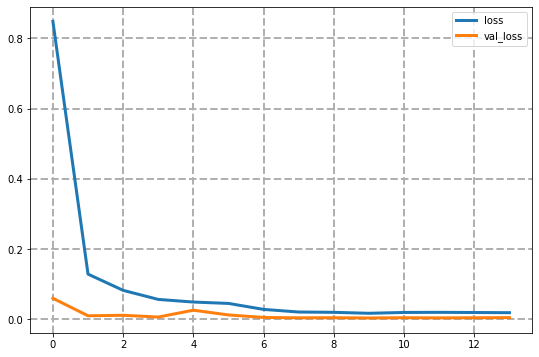

In [ ]:
#plot history and logger
pd.DataFrame(model.history.history)[['loss', 'val_loss']].plot(figsize = (9, 6), linewidth = 3)
plt.grid(linestyle = '--', linewidth = 2)
plt.show()


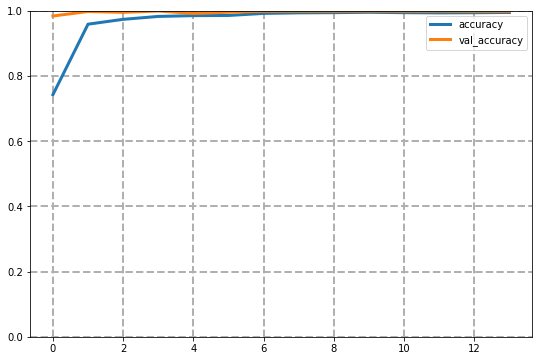

In [ ]:
#plot history and logger
pd.DataFrame(model.history.history)[['accuracy', 'val_accuracy']].plot(figsize = (9, 6), linewidth = 3)
plt.grid(linestyle = '--', linewidth = 2)
plt.ylim(0,1)
plt.show()


In [ ]:
#evaluate model
train_evaluation = model.evaluate(train_data, verbose = 0)
valid_evaluation = model.evaluate(test_data, verbose = 0)

print(f'Training Set Evaluation:\n\tLoss: {round(train_evaluation[0],4)}\tAccuracy: {round(100*train_evaluation[1],2)}%')
print(f'Validation Set Evaluation:\n\tLoss: {round(valid_evaluation[0],4)}\tAccuracy: {round(100*valid_evaluation[1],2)}%')


Training Set Evaluation:
	Loss: 0.0141	Accuracy: 99.58%
Validation Set Evaluation:
	Loss: 0.0067	Accuracy: 99.87%


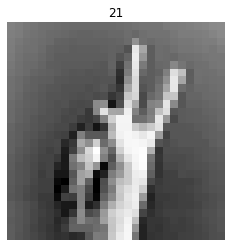

In [ ]:
#draw smaple image
img = valid_data.sample(1)
label = img.label.values
img = img.drop('label', axis = 1)

img = img.values.reshape((28,28))
img = img/255;

plt.axis('off')
plt.imshow(img, cmap = 'Greys')
plt.title(label[0])
plt.show()


In [ ]:
#model prediction
img = np.expand_dims(img, 0)
pred = pd.DataFrame(model.predict(img))
pred.round(4)


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.9999,0.0,0.0,0.0,0.0


In [ ]:
#save model
model.save('/content/sign-language-recognition-model.h5')
